In [1]:
import jax
import jax.numpy as jnp
from arraytainers import Jaxtainer
from approx_post.distributions import approx, joint, mixture
from approx_post import losses, optimisers
import seaborn as sns
import matplotlib.pyplot as plt
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

In [2]:
def create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey):
    mean = model(true_theta)
    samples = jax.random.multivariate_normal(key=prngkey, mean=mean, cov=noise_cov, shape=(num_samples,))
    return samples.reshape(num_samples, -1)

In [3]:
# First, let's define a model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [4]:
# Create artificial data:
prngkey = jax.random.PRNGKey(10)
true_theta = jnp.array([2])
noise_cov = 0.1*jnp.identity(ndim)
num_samples = 1
data = create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey)
print(f'True theta: \n {true_theta}')
print(f'True x = model(theta): \n {model(true_theta)}')
print(f'Observations x_obs = model(theta) + noise: \n {data}')

True theta: 
 [2]
True x = model(theta): 
 [4]
Observations x_obs = model(theta) + noise: 
 [[3.5748188]]


In [5]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = 1.*jnp.identity(ndim)
joint_dist = joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

In [15]:
mix_dist.params + Jaxtainer({'component_1':2})

TypeError: ufunc() missing 1 of 2required positional argument(s)

In [8]:
approx_dist = approx.Gaussian(ndim)
# mix_dist = mixture.Different([approx_dist, approx_dist])
mix_dist = mixture.Identical(approx_dist,4)

perturbation = {f'component_{i}': {'mean': val} for i, val in enumerate([-2., -2., 2., 2.])}
mix_dist.perturb(perturbation)

prngkey = jax.random.PRNGKey(12)
loss = losses.SELBO(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(mix_dist, loss, data, prngkey, verbose=True, max_iter=100, num_samples=50)

TypeError: fn() missing 1 required positional argument: 'x2'

In [7]:
mix_dist.add_component()

In [ ]:
def filter(grad):
    for i in range(1):
        grad[f'component_{i}'] = 0*grad[f'component_{i}']
    grad['log_unnorm_coeff'] = 0*grad['log_unnorm_coeff']
    return grad

perturbation = {'component_0': 0., 
                'component_1': Jaxtainer({'mean':0.5, 'log_chol_diag': -0.1}) , 
                'log_unnorm_coeff': 0.}
mix_dist.perturb(perturbation)

optimiser.fit(mix_dist, loss, data, prngkey, grad_filter=filter, verbose = True, max_iter=100, num_samples=1000)

In [ ]:
def filter(grad):
    for i in range(2):
        grad[f'component_{i}'] = 0*grad[f'component_{i}']
    return grad

optimiser.fit(mix_dist, loss, data, prngkey, grad_filter=filter, verbose = True, max_iter=100, num_samples=1000)

In [11]:
def plot_posteriors(approx_dist, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 5000)).reshape(1,-1,1)
    pdf = jnp.exp(approx_dist.logpdf(theta))
    ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze())
    ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("Posterior Probability Density")

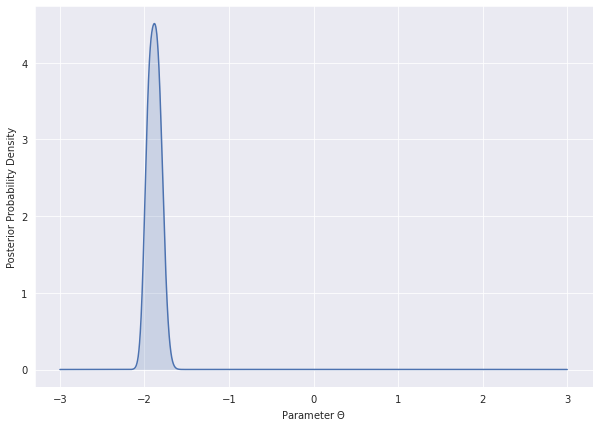

In [12]:
plot_posteriors(mix_dist)

In [12]:
mix_dist.phi()

Jaxtainer({'component_0': {'mean': DeviceArray([[-8.743457e-05]], dtype=float32), 'log_chol_diag': DeviceArray([[-3.7792566]], dtype=float32)}, 'component_1': {'mean': DeviceArray([[0.]], dtype=float32), 'log_chol_diag': DeviceArray([[0.]], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([[0., 0.]], dtype=float32)})